In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (256, 256),
    batch_size= 32    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 1 1 2 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 2 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[164. 155. 160.]
  [159. 150. 155.]
  [154. 145. 150.]
  ...
  [148. 137. 141.]
  [145. 134. 138.]
  [143. 132. 136.]]

 [[158. 149. 154.]
  [156. 147. 152.]
  [154. 145. 150.]
  ...
  [151. 140. 144.]
  [149. 138. 142.]
  [147. 136. 140.]]

 [[156. 147. 152.]
  [157. 148. 153.]
  [157. 148. 153.]
  ...
  [151. 140. 144.]
  [149. 138. 142.]
  [148. 137. 141.]]

 ...

 [[215. 209. 211.]
  [209. 203. 205.]
  [212. 206. 208.]
  ...
  [189. 180. 183.]
  [189. 180. 183.]
  [192. 183. 186.]]

 [[216. 210. 212.]
  [209. 203. 205.]
  [211. 205. 207.]
  ...
  [190. 181. 184.]
  [189. 180. 183.]
  [191. 182. 185.]]

 [[213. 207. 209.]
  [206. 200. 202.]
  [207. 201. 203.]
  ...
  [191. 182. 185.]
  [189. 180. 183.]
  [190. 181. 184.]]]


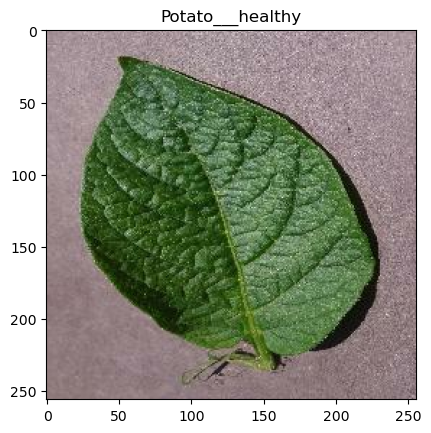

In [9]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype('uint8'))
    plt.title(class_names[label_batch[0]])

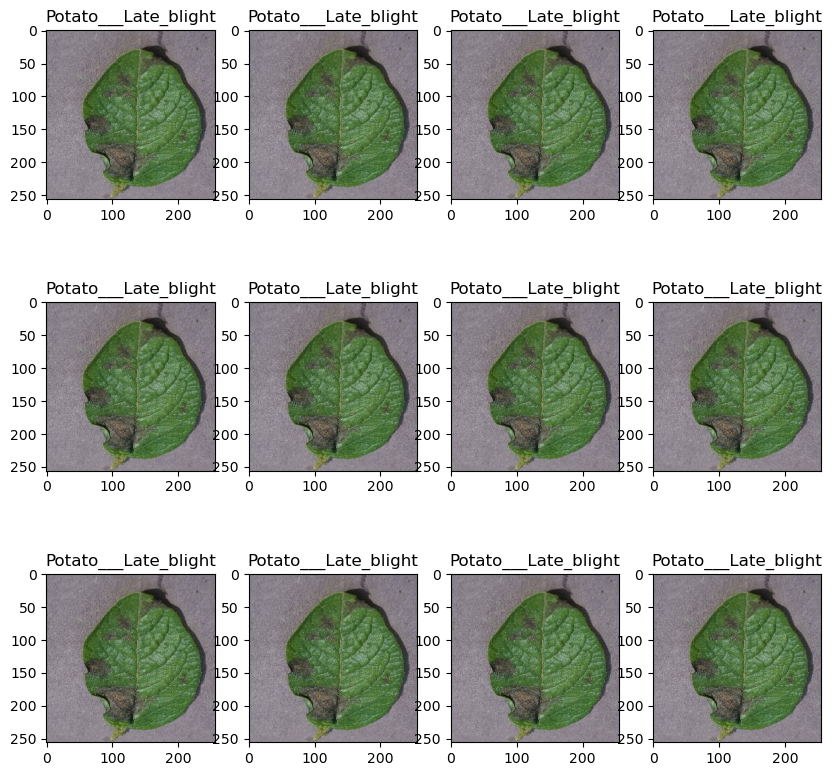

In [10]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)    
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3


input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 87s 2s/step - loss: 0.9307 - accuracy: 0.4688 - val_loss: 0.8061 - val_accuracy: 0.5521
Epoch 2/20
54/54 [==============================] - 80s 1s/step - loss: 0.7633 - accuracy: 0.6348 - val_loss: 0.7949 - val_accuracy: 0.6302
Epoch 3/20
54/54 [==============================] - 74s 1s/step - loss: 0.5997 - accuracy: 0.7500 - val_loss: 0.4697 - val_accuracy: 0.7708
Epoch 4/20
54/54 [==============================] - 79s 1s/step - loss: 0.4858 - accuracy: 0.7940 - val_loss: 0.4760 - val_accuracy: 0.8438
Epoch 5/20
54/54 [==============================] - 80s 1s/step - loss: 0.3539 - accuracy: 0.8652 - val_loss: 0.7629 - val_accuracy: 0.7448
Epoch 6/20
54/54 [==============================] - 78s 1s/step - loss: 0.2770 - accuracy: 0.9010 - val_loss: 0.5600 - val_accuracy: 0.7865
Epoch 7/20
54/54 [==============================] - 85s 2s/step - loss: 0.2469 - accuracy: 0.9132 - val_loss: 0.4616 - val_accuracy: 0.8125
Epoch 8/20
54/54 [==

In [27]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 3s 256ms/step - loss: 0.8539 - accuracy: 0.7852


In [28]:
scores

[0.8538790345191956, 0.78515625]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [31]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])


list

In [33]:
len(history.history['loss'])


20

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9307100772857666,
 0.7632536888122559,
 0.5997340083122253,
 0.4857918322086334,
 0.3538976013660431]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

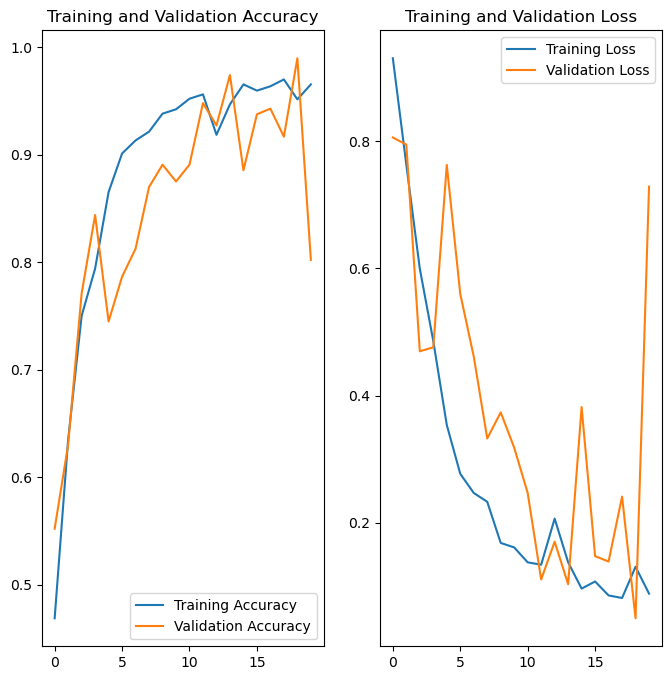

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 364ms/step
predicted label: Potato___Early_blight


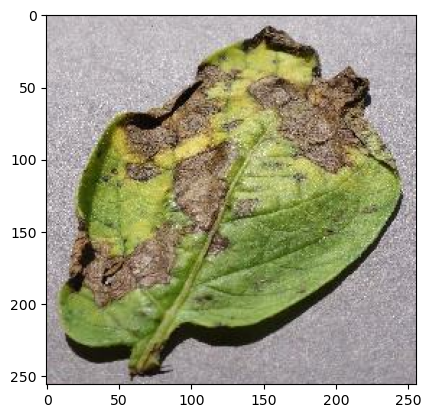

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


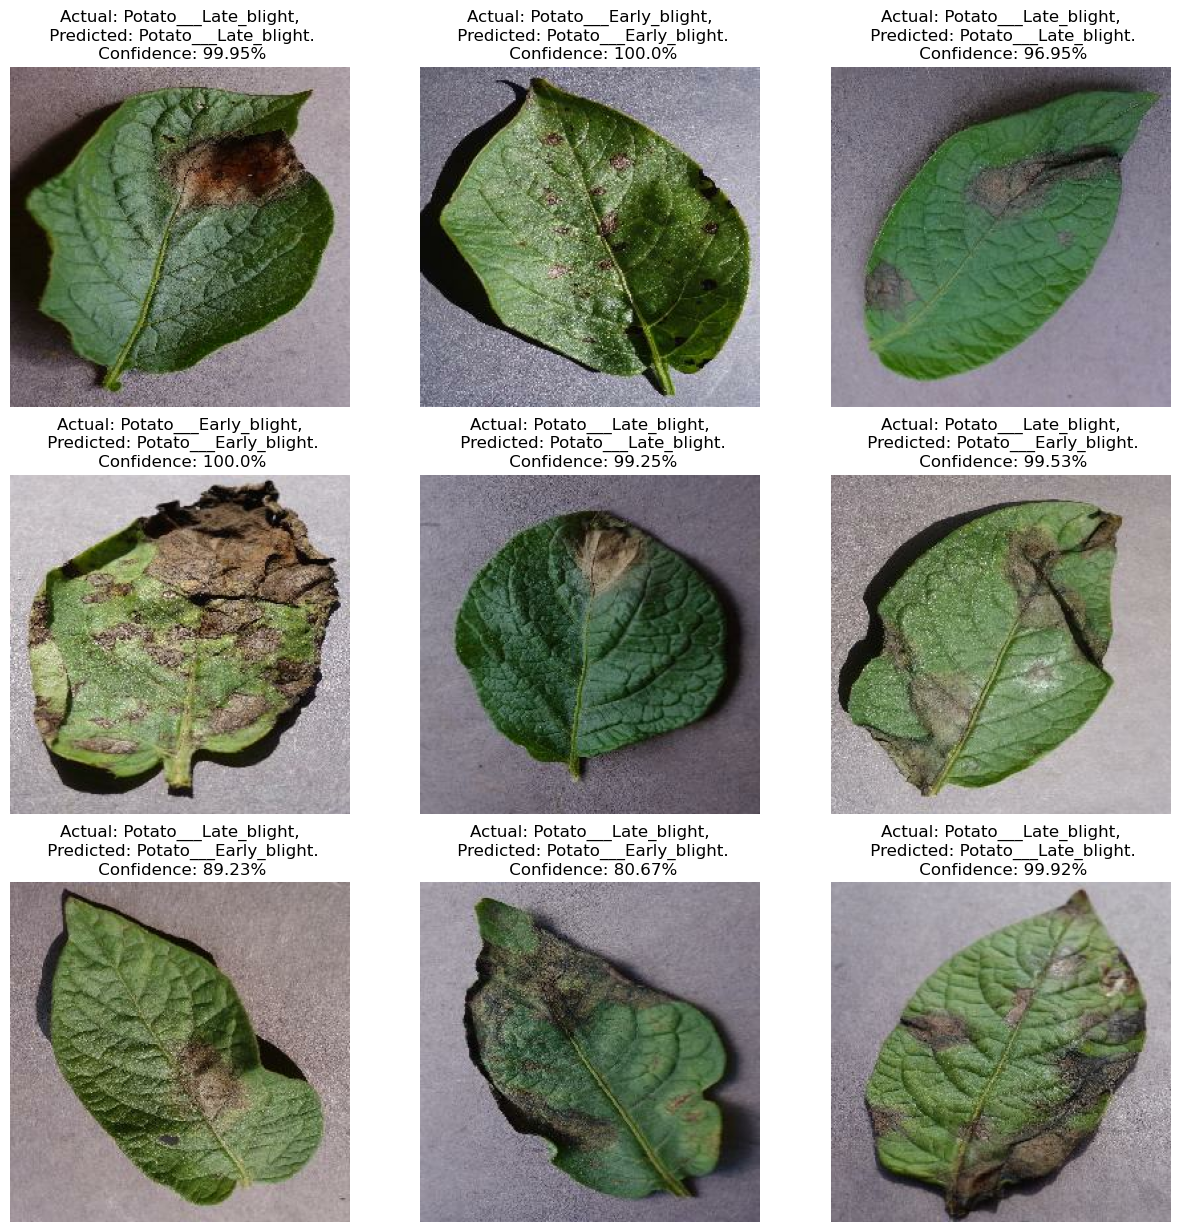

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")